## Library Imports and Configuration

This cell imports the necessary libraries and configures some parameters for the project. It includes libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), text processing (`nltk`), and machine learning (`sklearn`, `surprise`). It also sets up paths and parameters for data loading and model export.

In [4]:
!pip install scikit-surprise


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/files2rouge-2.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-macosx_11_0_arm64.whl size=485277 sha256=301126be2dc2f861f435380002e1f616b79731f6acb5a2063611ee0207a0c3f8
  Stored in directory: /Users/yogeshneupane/Library/Caches/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A 

In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV as SklearnGridSearchCV
from surprise.model_selection import GridSearchCV as SurpriseGridSearchCV
from surprise.model_selection import cross_validate, train_test_split as surprise_train_test_split
from surprise import SVDpp, Dataset, Reader
from surprise import accuracy

# Ensure NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Paths and parameters
DATA_PATH = './Reviews.csv'
SAMPLE_SIZE = 500000
MODEL_EXPORT_PATH = 'model_artifacts.pkl'
ALPHA = 0.7  # hybrid weighting

## Data Loading

This cell defines a function to preprocess text by tokenizing and removing stopwords. It then loads the dataset from a CSV file and optionally samples a subset of the data to speed up processing.

In [9]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

# Load dataset
df = pd.read_csv(DATA_PATH)

population_size = len(df)
print(f"Population size: {population_size}")

# We are implementing Sampling here since the dataset is huge. So Sampling a subset to speed up
# df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

Population size: 568454


## Data Cleaning & Preprocessing

This cell performs data cleaning by removing duplicates and filtering out users and items with fewer than a specified number of reviews. It also converts the `Time` column to datetime format and calculates the `HelpfulnessRatio`. The cleaned data is stored in `ratings_df`.

In [12]:
# Remove duplicates
df.drop_duplicates(subset=['UserId', 'ProductId', 'Time', 'Summary', 'Text'], inplace=True)
df.dropna(subset=['UserId', 'ProductId', 'Score'], inplace=True)

# Basic filtering: Keep only users/items with minimum number of reviews
min_ratings_per_user = 10
min_ratings_per_item = 10

user_counts = df['UserId'].value_counts()
item_counts = df['ProductId'].value_counts()

df = df[df['UserId'].isin(user_counts[user_counts >= min_ratings_per_user].index)]
df = df[df['ProductId'].isin(item_counts[item_counts >= min_ratings_per_item].index)]
df.reset_index(drop=True, inplace=True)

df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
df.loc[df['HelpfulnessDenominator'] == 0, 'HelpfulnessDenominator'] = np.nan
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# For the recommendation tasks, we primarily need these columns:
ratings_df = df[['UserId', 'ProductId', 'Score', 'Summary', 'Text', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio']]## Exploratory Data Analysis (EDA)

## Exploratory Data Analysis (EDA)

## Basic Dataset Information

This cell prints basic information and statistics about the dataset, including the number of unique users and products, and the sparsity of the rating matrix.

In [16]:
print("Basic Dataset Info:")
print(df.info())


Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116101 entries, 0 to 116100
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116101 non-null  int64         
 1   ProductId               116101 non-null  object        
 2   UserId                  116101 non-null  object        
 3   ProfileName             116101 non-null  object        
 4   HelpfulnessNumerator    116101 non-null  int64         
 5   HelpfulnessDenominator  63044 non-null   float64       
 6   Score                   116101 non-null  int64         
 7   Time                    116101 non-null  datetime64[ns]
 8   Summary                 116076 non-null  object        
 9   Text                    116101 non-null  object        
 10  HelpfulnessRatio        63044 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.7

In [18]:
print("\nBasic Statistics:")
print(df.describe(include='all'))


Basic Statistics:
                   Id   ProductId          UserId       ProfileName  \
count   116101.000000      116101          116101            116101   
unique            NaN        9229            7500              7324   
top               NaN  B002IEZJMA  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
freq              NaN         390             292               292   
mean    280959.320049         NaN             NaN               NaN   
min         14.000000         NaN             NaN               NaN   
25%     139798.000000         NaN             NaN               NaN   
50%     281712.000000         NaN             NaN               NaN   
75%     416106.000000         NaN             NaN               NaN   
max     568398.000000         NaN             NaN               NaN   
std     162275.595356         NaN             NaN               NaN   

        HelpfulnessNumerator  HelpfulnessDenominator          Score  \
count          116101.000000            63044.000000  116

## Ratings Distribution

This cell visualizes the distribution of ratings in the dataset using a histogram.


Number of unique users: 7500
Number of unique products: 9229


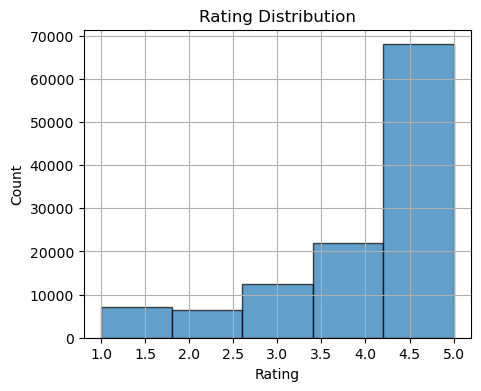

Sparsity of the rating matrix: 0.9983


In [21]:
num_users = ratings_df['UserId'].nunique()
num_items = ratings_df['ProductId'].nunique()
print(f"\nNumber of unique users: {num_users}")
print(f"Number of unique products: {num_items}")

# Ratings Distribution
plt.figure(figsize=(5,4))
ratings_df['Score'].hist(bins=5, edgecolor='black', alpha=0.7)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Sparsity calculation
total_possible_interactions = num_users * num_items
actual_interactions = len(ratings_df)
sparsity = 1 - (actual_interactions / total_possible_interactions)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")


## Distribution of Number of Reviews per User

This cell visualizes the distribution of the number of reviews per user using a histogram.

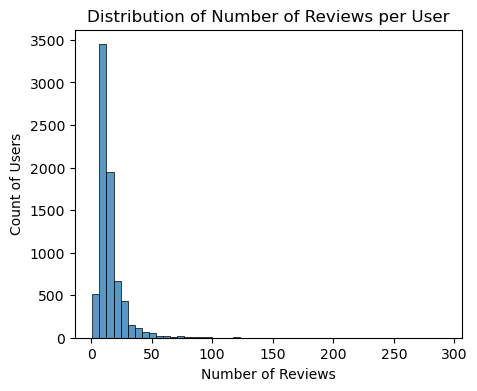

In [24]:
# Distribution of number of reviews per user
plt.figure(figsize=(5,4))
user_review_counts = ratings_df.groupby('UserId')['ProductId'].count()
sns.histplot(user_review_counts, bins=50, kde=False)
plt.title('Distribution of Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Users')
plt.show()

## Distribution of Number of Reviews per Product

This cell visualizes the distribution of the number of reviews per product using a histogram.

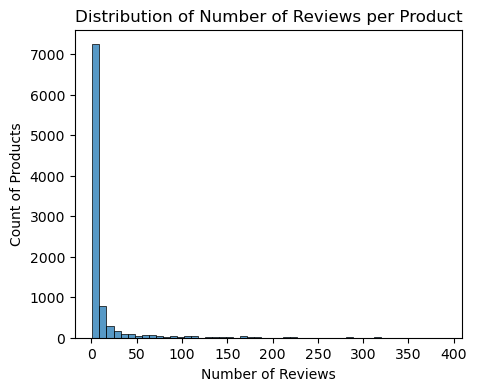

In [27]:

# Distribution of number of reviews per product
plt.figure(figsize=(5,4))
item_review_counts = ratings_df.groupby('ProductId')['UserId'].count()
sns.histplot(item_review_counts, bins=50, kde=False)
plt.title('Distribution of Number of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Products')
plt.show()




## Reviews Over Time

This cell visualizes the number of reviews over time using a line plot.

/var/folders/x_/krn821251zdbmbqf3vm0jg040000gn/T/ipykernel_47416/3616123788.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  reviews_per_year = ratings_df.set_index('Time').resample('Y').count()['Score']


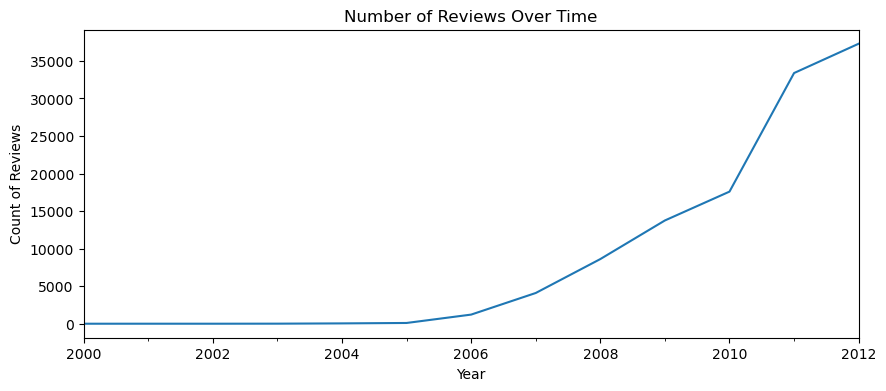

In [30]:
# Time-based Analysis: Reviews over time
plt.figure(figsize=(10,4))
reviews_per_year = ratings_df.set_index('Time').resample('Y').count()['Score']
reviews_per_year.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.show()


## Helpfulness Numerator vs. Score

This cell visualizes the relationship between the helpfulness numerator and the score using a scatter plot.

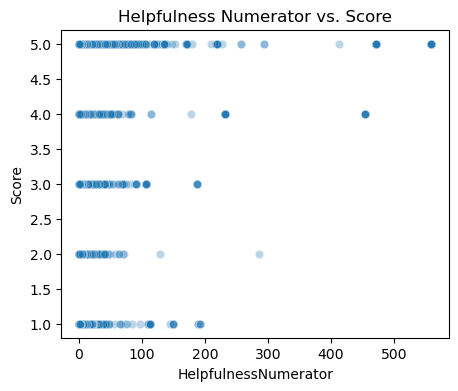

In [33]:
# Relationship between Helpfulness and Score
plt.figure(figsize=(5,4))
sns.scatterplot(x='HelpfulnessNumerator', y='Score', data=ratings_df, alpha=0.3)
plt.title('Helpfulness Numerator vs. Score')
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('Score')
plt.show()

## Helpfulness Ratio Distribution

This cell visualizes the distribution of the helpfulness ratio using a histogram.

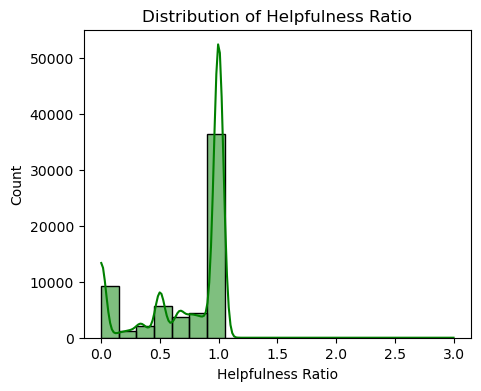

In [36]:
# Helpfulness Ratio distribution
plt.figure(figsize=(5,4))
valid_ratios = ratings_df['HelpfulnessRatio'].dropna()
sns.histplot(valid_ratios, bins=20, kde=True, color='green')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Count')
plt.show()

## Correlation Heatmap

This cell visualizes the correlation between numeric columns in the dataset using a heatmap.

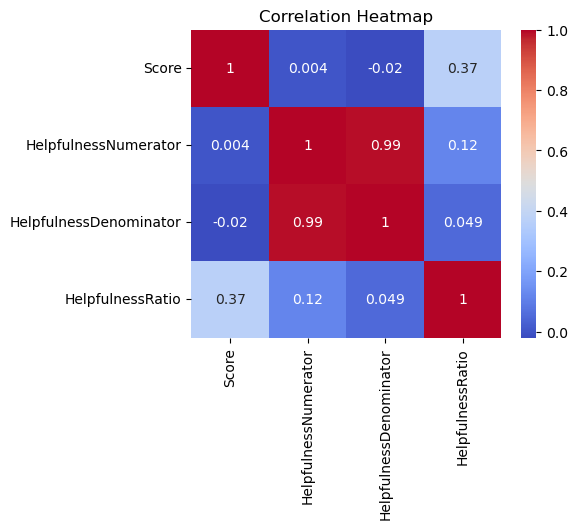

In [39]:
# Correlation heatmap
numeric_cols = ['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio']
corr = ratings_df[numeric_cols].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Review Length Analysis

This cell calculates the length of each review in words and visualizes the distribution of review lengths using a histogram.

/var/folders/x_/krn821251zdbmbqf3vm0jg040000gn/T/ipykernel_47416/3210171034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['ReviewLength'] = ratings_df['Text'].fillna('').apply(lambda x: len(x.split()))


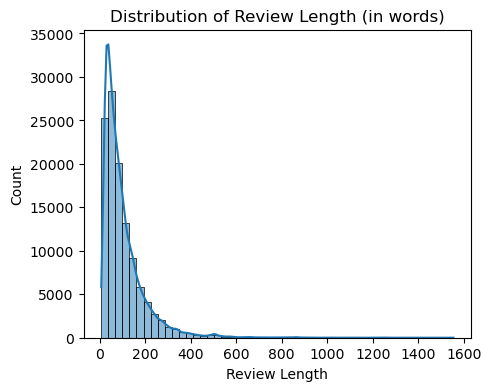

In [42]:
# Text length analysis
ratings_df['ReviewLength'] = ratings_df['Text'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(5,4))
sns.histplot(ratings_df['ReviewLength'], bins=50, kde=True)
plt.title('Distribution of Review Length (in words)')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

## Review Length vs. Score

This cell visualizes the relationship between review length and score using a box plot.

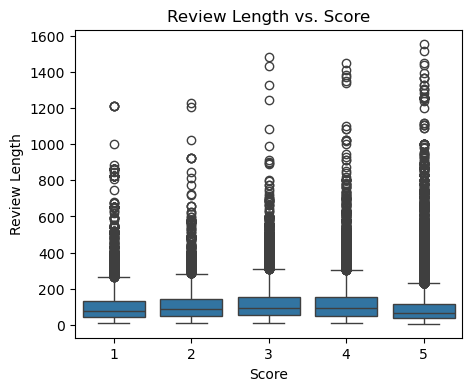

In [45]:
# Does review length correlate with score?
plt.figure(figsize=(5,4))
sns.boxplot(x='Score', y='ReviewLength', data=ratings_df)
plt.title('Review Length vs. Score')
plt.xlabel('Score')
plt.ylabel('Review Length')
plt.show()

## Top 5 Users and Items

This cell prints the top 5 users and items by the number of reviews.

In [48]:
# Top 5 users and items
print("\nTop 5 users by number of reviews:")
print(user_review_counts.sort_values(ascending=False).head())

print("\nTop 5 items by number of reviews:")
print(item_review_counts.sort_values(ascending=False).head())


Top 5 users by number of reviews:
UserId
A3OXHLG6DIBRW8    292
A281NPSIMI1C2R    216
A1YUL9PCJR3JTY    184
A1TMAVN4CEM8U8    177
A2SZLNSI5KOQJT    164
Name: ProductId, dtype: int64

Top 5 items by number of reviews:
ProductId
B002IEZJMA    390
B006MONQMC    379
B002IEVJRY    373
B0041NYV8E    361
B003GTR8IO    328
Name: UserId, dtype: int64


## Feature Engineering for Hybrid Approach

This cell performs feature engineering by combining and preprocessing text data, creating a TF-IDF matrix, and calculating item similarity using cosine similarity.

In [51]:
ratings_df['CombinedText'] = (ratings_df['Summary'].fillna('') + ' ' + ratings_df['Text'].fillna('')).str.lower()

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

ratings_df['ProcessedText'] = ratings_df['CombinedText'].apply(remove_stopwords)

item_texts = ratings_df.groupby('ProductId')['ProcessedText'].apply(lambda x: ' '.join(x)).reset_index()
item_texts.drop_duplicates('ProductId', inplace=True)

tfidf = TfidfVectorizer(max_features=5000)
item_tfidf = tfidf.fit_transform(item_texts['ProcessedText'])

item_index_map = {pid: idx for idx, pid in enumerate(item_texts['ProductId'])}
index_item_map = {idx: pid for pid, idx in item_index_map.items()}

item_similarity = cosine_similarity(item_tfidf)

## Model Selection & Building (Collaborative Filtering)

This cell sets up the collaborative filtering model using the `SVDpp` algorithm from the `surprise` library. It splits the data into training and test sets, trains the model, and performs cross-validation.

In [53]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_df[['UserId','ProductId','Score']], reader)

trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
algo = SVDpp(random_state=42)
algo.fit(trainset)

baseline_results = cross_validate(algo, data, measures=['RMSE','MAE'], cv=3, verbose=True)
print("\nBaseline SVD++ CV Results:", baseline_results)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7952  0.7973  0.7959  0.7961  0.0009  
MAE (testset)     0.5301  0.5300  0.5296  0.5299  0.0002  
Fit time          1.45    1.46    1.48    1.47    0.01    
Test time         0.72    0.80    0.72    0.75    0.04    

Baseline SVD++ CV Results: {'test_rmse': array([0.79515162, 0.79725716, 0.79594862]), 'test_mae': array([0.53008697, 0.52997227, 0.52956083]), 'fit_time': (1.4531691074371338, 1.463961124420166, 1.4785020351409912), 'test_time': (0.7227797508239746, 0.8002791404724121, 0.717926025390625)}


## Hyperparameter Tuning

This cell performs hyperparameter tuning for the `SVDpp` model using grid search to find the best parameters based on RMSE and MAE.

In [55]:
param_grid = {
    'n_factors': [50,100,150],
    'n_epochs': [10,20],
    'lr_all': [0.002,0.005],
    'reg_all': [0.02,0.1,0.2]
}

gs = SurpriseGridSearchCV(SVDpp, param_grid, measures=['rmse','mae'], cv=3, n_jobs=-1)
gs.fit(data)

print("Best RMSE score attained: ", gs.best_score['rmse'])
print("Best parameters: ", gs.best_params['rmse'])

best_algo = SVDpp(**gs.best_params['rmse'], random_state=42)
full_trainset = data.build_full_trainset()
best_algo.fit(full_trainset)

Best RMSE score attained:  0.8220135179191098
Best parameters:  {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


## Model Evaluation

This cell evaluates the trained model on the test set, calculating RMSE and MAE. It also defines a function to calculate precision and recall at k.

In [57]:
predictions = best_algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = {}
    for uid, iid, true_r, est, _ in predictions:
        user_est_true.setdefault(uid, []).append((est, true_r))

    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, true_r) in top_k)

        if n_rel > 0:
            precisions.append(n_rec_k / k)
            recalls.append(n_rec_k / n_rel)

    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

RMSE: 0.4717
MAE:  0.3053

Test RMSE: 0.4717
Test MAE: 0.3053
Precision@10: 0.2932
Recall@10: 0.9949


## Hybrid Recommendation Logic

This cell defines a function to generate hybrid recommendations for a user by combining collaborative filtering predictions with content-based similarity scores.

In [63]:
def hybrid_recommendations(user_id, top_n=10):
    user_items = ratings_df[ratings_df['UserId']==user_id]['ProductId'].unique()
    user_unrated = [iid for iid in item_texts['ProductId'].unique() if iid not in user_items]

    cf_predictions = []
    for iid in user_unrated:
        pred = best_algo.predict(user_id, iid)
        cf_predictions.append((iid, pred.est))
    cf_predictions.sort(key=lambda x: x[1], reverse=True)

    user_highly_rated = ratings_df[(ratings_df['UserId']==user_id) & (ratings_df['Score']>=4)]['ProductId'].unique()
    user_highly_rated_indices = [item_index_map[i] for i in user_highly_rated if i in item_index_map]

    hybrid_scores = []
    for (iid, cf_score) in cf_predictions:
        if iid not in item_index_map:
            hybrid_scores.append((iid, cf_score))
            continue
        idx = item_index_map[iid]
        if len(user_highly_rated_indices) > 0:
            sim_scores = item_similarity[idx, user_highly_rated_indices]
            content_score = np.mean(sim_scores)
        else:
            content_score = 0

        hybrid_score = ALPHA * cf_score + (1 - ALPHA) * content_score
        hybrid_scores.append((iid, hybrid_score))

    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    return hybrid_scores[:top_n]